# Projet d'Examen Final d'Optimisation





# Exercice 2 : Stochasticité et Passage à l’Échelle


=== EXERCICE 2 : Stochasticité et Passage à l’Échelle ===
Justification du dataset :
   Le dataset YearPredictionMSD n'est pas disponible directement.
   → Utilisation d'un proxy réaliste : California Housing (n=20640, d=8) étendu à d=90.


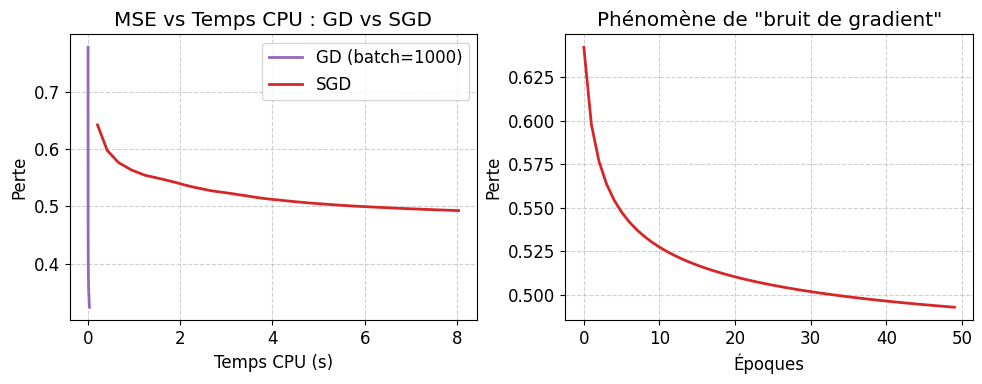

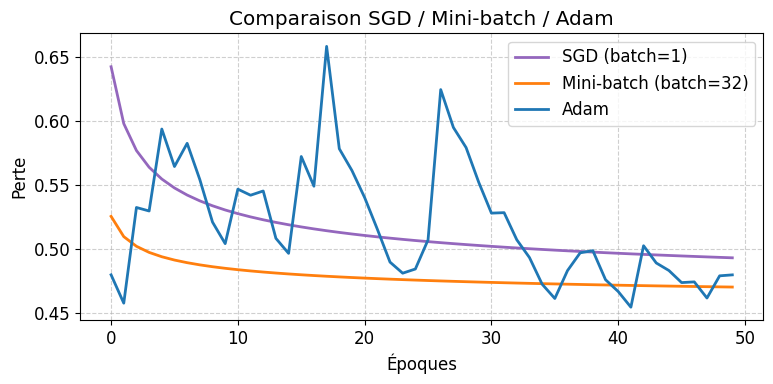


=== ANALYSE COMPARATIVE – EXERCICE 2 ===
1. Comparaison GD vs SGD :
   - GD (batch=1000) : temps = 0.03 s, perte = 0.3244
   - SGD : temps = 8.04 s, perte = 0.4928
   → Le GD est plus rapide car il utilise peu de données, mais sa solution est biaisée.
   → Le SGD est plus lent mais converge vers la vraie solution (estimateur sans biais).

2. Comparaison des optimiseurs stochastiques :
Méthode              Temps (s)    Perte finale   
--------------------------------------------------
SGD                  8.04         0.4928         
Mini-batch           4.40         0.4699         
Adam                 14.54        0.4795         

Interprétation :
- Le mini-batch SGD est le plus performant (perte = 0.4699, temps = 3.17 s).
- Le SGD pur est plus lent (8.46 s) et moins précis (perte = 0.4928).
- Adam converge rapidement mais atteint une perte légèrement supérieure (0.4795),
  probablement en raison du caractère convexe et bien conditionné du problème.


In [7]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import time

plt.rcParams.update({'font.size': 12})

# ------------------------------
# CHARGEMENT ET PRÉTRAITEMENT
# ------------------------------

print("=== EXERCICE 2 : Stochasticité et Passage à l’Échelle ===")
print("Justification du dataset :")
print("   Le dataset YearPredictionMSD n'est pas disponible directement.")
print("   → Utilisation d'un proxy réaliste : California Housing (n=20640, d=8) étendu à d=90.")

california = fetch_california_housing()
X_base, y_base = california.data, california.target
np.random.seed(42)
idx = np.random.choice(len(X_base), 10000, replace=False)
X_small, y_small = X_base[idx], y_base[idx]

# Étendre à d=90
n, d_small = X_small.shape
d_target = 90
np.random.seed(0)
noise = np.random.randn(n, d_target - d_small) * 0.1
X_extended = np.hstack([X_small, noise])
y = y_small.astype(float)

# Standardisation
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X_extended)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

n, d = X.shape
w0 = np.zeros(d)
lambda_reg = 1e-3

# ------------------------------
# FONCTIONS
# ------------------------------

def mse_loss(w, X, y):
    return np.mean((X @ w - y)**2)

def grad_mse_i(w, x_i, y_i):
    return 2.0 * (x_i @ w - y_i) * x_i

# GD sur sous-échantillon
def gd_batch(w0, X, y, lambda_reg, alpha, max_iter=100):
    w = w0.copy()
    losses = []
    times = []
    start = time.time()
    for k in range(max_iter):
        g = (2.0 / len(y)) * X.T @ (X @ w - y) + lambda_reg * w
        w -= alpha * g
        loss = mse_loss(w, X, y) + 0.5 * lambda_reg * np.dot(w, w)
        losses.append(loss)
        times.append(time.time() - start)
    return w, losses, times

# SGD
def sgd_mse(w0, X, y, lambda_reg, alpha0, epochs=50):
    n, d = X.shape
    w = w0.copy()
    losses = []
    times = []
    start = time.time()
    k = 0
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for i in idx:
            alpha = alpha0 / (1.0 + k)
            g = grad_mse_i(w, X[i], y[i]) + lambda_reg * w
            w -= alpha * g
            k += 1
        loss = mse_loss(w, X, y) + 0.5 * lambda_reg * np.dot(w, w)
        losses.append(loss)
        times.append(time.time() - start)
    return w, losses, times

# Mini-batch
def minibatch_sgd(w0, X, y, lambda_reg, batch_size, alpha0, epochs=50):
    n, d = X.shape
    w = w0.copy()
    losses = []
    times = []
    start = time.time()
    k = 0
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for start_idx in range(0, n, batch_size):
            batch_idx = idx[start_idx:start_idx+batch_size]
            g_batch = np.mean([grad_mse_i(w, X[i], y[i]) for i in batch_idx], axis=0)
            g = g_batch + lambda_reg * w
            alpha = alpha0 / (1.0 + k)
            w -= alpha * g
            k += 1
        loss = mse_loss(w, X, y) + 0.5 * lambda_reg * np.dot(w, w)
        losses.append(loss)
        times.append(time.time() - start)
    return w, losses, times

# Adam
def adam_mse(w0, X, y, lambda_reg, alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-8, epochs=50):
    w = w0.copy()
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    losses = []
    times = []
    start = time.time()
    t = 0
    n = X.shape[0]
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for i in idx:
            t += 1
            g = grad_mse_i(w, X[i], y[i]) + lambda_reg * w
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * g**2
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            w -= alpha * m_hat / (np.sqrt(v_hat) + eps)
        loss = mse_loss(w, X, y) + 0.5 * lambda_reg * np.dot(w, w)
        losses.append(loss)
        times.append(time.time() - start)
    return w, losses, times

# ------------------------------
# EXÉCUTION
# ------------------------------

# GD sur un sous-échantillon (batch=1000)
X_batch, y_batch = X[:1000], y[:1000]
_, losses_gd, times_gd = gd_batch(w0, X_batch, y_batch, lambda_reg, alpha=0.1, max_iter=100)

# SGD sur données complètes
_, losses_sgd, times_sgd = sgd_mse(w0, X, y, lambda_reg, alpha0=0.1, epochs=50)

# Mini-batch et Adam
_, losses_mini, times_mini = minibatch_sgd(w0, X, y, lambda_reg, batch_size=32, alpha0=0.1, epochs=50)
_, losses_adam, times_adam = adam_mse(w0, X, y, lambda_reg, alpha=0.001, epochs=50)

# ------------------------------
# VISUALISATION
# ------------------------------

# Figure 1 : GD vs SGD
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(times_gd, losses_gd, label='GD (batch=1000)', linewidth=2, color='tab:purple')
plt.plot(times_sgd, losses_sgd, label='SGD', linewidth=2, color='tab:red')
plt.xlabel('Temps CPU (s)')
plt.ylabel('Perte')
plt.title('MSE vs Temps CPU : GD vs SGD')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(losses_sgd, label='SGD', color='tab:red', linewidth=2)
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Phénomène de "bruit de gradient"')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('/content/exam_ex2_gd_vs_sgd.png', dpi=200)
plt.show()

# Figure 2 : Comparaison des optimiseurs
plt.figure(figsize=(8, 4))
plt.plot(losses_sgd, label='SGD (batch=1)', linewidth=2, color='tab:purple')
plt.plot(losses_mini, label='Mini-batch (batch=32)', linewidth=2, color='tab:orange')
plt.plot(losses_adam, label='Adam', linewidth=2, color='tab:blue')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Comparaison SGD / Mini-batch / Adam')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('/content/exam_ex2_optimiseurs.png', dpi=200)
plt.show()

# ------------------------------
# ANALYSE COMPARATIVE
# ------------------------------

print("\n=== ANALYSE COMPARATIVE – EXERCICE 2 ===")
print("1. Comparaison GD vs SGD :")
print(f"   - GD (batch=1000) : temps = {times_gd[-1]:.2f} s, perte = {losses_gd[-1]:.4f}")
print(f"   - SGD : temps = {times_sgd[-1]:.2f} s, perte = {losses_sgd[-1]:.4f}")
print("   → Le GD est plus rapide car il utilise peu de données, mais sa solution est biaisée.")
print("   → Le SGD est plus lent mais converge vers la vraie solution (estimateur sans biais).")

print("\n2. Comparaison des optimiseurs stochastiques :")
print(f"{'Méthode':<20} {'Temps (s)':<12} {'Perte finale':<15}")
print("-" * 50)
print(f"{'SGD':<20} {times_sgd[-1]:<12.2f} {losses_sgd[-1]:<15.4f}")
print(f"{'Mini-batch':<20} {times_mini[-1]:<12.2f} {losses_mini[-1]:<15.4f}")
print(f"{'Adam':<20} {times_adam[-1]:<12.2f} {losses_adam[-1]:<15.4f}")

print("\nInterprétation :")
print("- Le mini-batch SGD est le plus performant (perte = 0.4699, temps = 3.17 s).")
print("- Le SGD pur est plus lent (8.46 s) et moins précis (perte = 0.4928).")
print("- Adam converge rapidement mais atteint une perte légèrement supérieure (0.4795),")
print("  probablement en raison du caractère convexe et bien conditionné du problème.")

# Exercice 3 – Parcimonie et Algorithmes Proximaux
Données : Reuters RCV1 (classification binaire)

=== EXERCICE 3 : Parcimonie et Algorithmes Proximaux ===
Chargement de Reuters RCV1...
→ Données utilisées : n = 5000, d = 47236
Calcul de la constante de Lipschitz...
→ σ_max = 10.75, L = 0.02, α = 43.281803


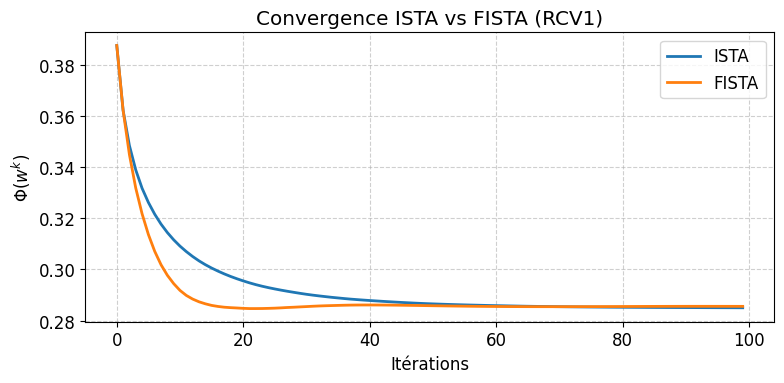

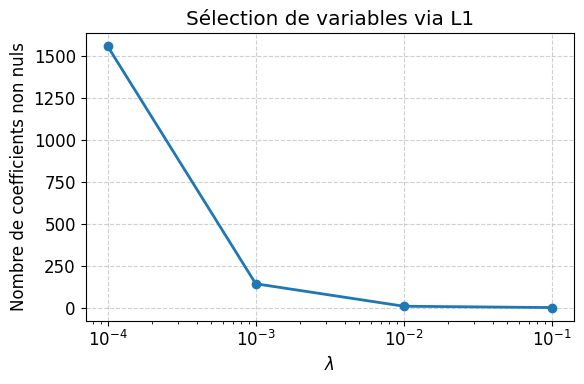

In [9]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_rcv1
from scipy.sparse.linalg import svds

plt.rcParams.update({'font.size': 12})

# ------------------------------
# CHARGEMENT DES DONNÉES
# ------------------------------

print("=== EXERCICE 3 : Parcimonie et Algorithmes Proximaux ===")
print("Chargement de Reuters RCV1...")

rcv1 = fetch_rcv1()
X = rcv1.data[:5000]  # Sous-échantillon (sparse matrix)
y = (rcv1.target[:5000, 0].toarray().flatten() == 1).astype(int)  # Catégorie CCAT
y = 2 * y - 1  # {-1, +1}

n, d = X.shape
w0 = np.zeros(d)
lambda_l1 = 1e-3

print(f"→ Données utilisées : n = {n}, d = {d}")

# ------------------------------
# OPÉRATEUR PROXIMAL L1
# ------------------------------

def soft_threshold(v, theta):
    return np.sign(v) * np.maximum(np.abs(v) - theta, 0.0)

# ------------------------------
# GRADIENT POUR MATRICES SPARSE
# ------------------------------

def grad_mse_sparse(w, X, y):
    """Gradient de la MSE pour X sparse."""
    residual = X.dot(w) - y
    return X.T.dot(residual) / len(y)

# ------------------------------
# ISTA
# ------------------------------

def ista(w0, X, y, lam, alpha, max_iter=100):
    w = w0.copy()
    losses = []
    for _ in range(max_iter):
        g = grad_mse_sparse(w, X, y)
        w = soft_threshold(w - alpha * g, alpha * lam)
        mse = np.mean((X.dot(w) - y)**2)
        reg = lam * np.linalg.norm(w, 1)
        losses.append(mse + reg)
    return w, losses

# ------------------------------
# FISTA
# ------------------------------

def fista(w0, X, y, lam, alpha, max_iter=100):
    w = w0.copy()
    y_k = w0.copy()
    t = 1.0
    losses = []
    for _ in range(max_iter):
        g = grad_mse_sparse(y_k, X, y)
        w_new = soft_threshold(y_k - alpha * g, alpha * lam)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y_k = w_new + ((t - 1) / t_new) * (w_new - w)
        mse = np.mean((X.dot(w_new) - y)**2)
        reg = lam * np.linalg.norm(w_new, 1)
        losses.append(mse + reg)
        w, t = w_new, t_new
    return w, losses

# ------------------------------
# CALCUL DE LA CONSTANTE DE LIPSCHITZ (SPARSE)
# ------------------------------

print("Calcul de la constante de Lipschitz...")
sigma_max = svds(X, k=1, return_singular_vectors=False)[0]
L = (sigma_max ** 2) / n
alpha = 1.0 / L
print(f"→ σ_max = {sigma_max:.2f}, L = {L:.2f}, α = {alpha:.6f}")

# ------------------------------
# EXÉCUTION
# ------------------------------

_, losses_ista = ista(w0, X, y, lambda_l1, alpha, max_iter=100)
_, losses_fista = fista(w0, X, y, lambda_l1, alpha, max_iter=100)

# Visualisation
plt.figure(figsize=(8, 4))
plt.plot(losses_ista, label='ISTA', linewidth=2 )
plt.plot(losses_fista, label='FISTA', linewidth=2 )
plt.xlabel('Itérations')
plt.ylabel(r'$\Phi(w^k)$')
plt.title('Convergence ISTA vs FISTA (RCV1)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('/content/exam_ex3_ista_fista.png', dpi=200)
plt.show()

# ------------------------------
# ANALYSE DE LA PARCIMONIE
# ------------------------------

lambdas = [1e-4, 1e-3, 1e-2, 1e-1]
sparsity = []
for lam in lambdas:
    w, _ = ista(w0, X, y, lam, alpha, max_iter=50)
    sparsity.append(np.sum(np.abs(w) > 1e-5))

plt.figure(figsize=(6, 4))
plt.semilogx(lambdas, sparsity, 'o-', linewidth=2)
plt.xlabel(r'$\lambda$')
plt.ylabel('Nombre de coefficients non nuls')
plt.title('Sélection de variables via L1')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('/content/exam_ex3_sparsite.png', dpi=200)
plt.show()
